In [1]:
# CONFIGURATION SECTION

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
from torchvision.io import read_image

# -----------------------
# REPRODUCIBILITY
# -----------------------
def set_seed(seed=42):                                              # function that set the same randomness everytime
    import random, numpy as np, torch                               # libs that control randomness
    random.seed(seed)                                               # make python random numbers repeatable
    np.random.seed(seed)                                            # make numpy random numbers repeatable
    torch.manual_seed(seed)                                         # make pytorch cpu random numbers repeatable
    torch.cuda.manual_seed(seed)                                    # make gpu/cuda random numbers repeatable
    torch.cuda.manual_seed_all(seed)                                # in case of multiple GPU
    torch.backends.cudnn.deterministic = True                       # make GPU ops behave same at each run
    torch.backends.cudnn.benchmark = False                          # turnoff seed that can cause randomnes

set_seed(42)                                                        # apply above setting using seed 42

def worker_init(worker_id):                                         # control randomness inside dataloaders workers each worker gets unique repeatable numpy, python seed
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)


# FILE PATH
image_root_dir = "/kaggle/input/faceforensics-extracted-dataset-c23/FF++C32-Frames"
ORIGINAL_CSV = "/kaggle/input/faceforensics-extracted-dataset-c23/CSVs/Original.csv"
DEEPFAKES_CSV = "/kaggle/input/faceforensics-extracted-dataset-c23/CSVs/Deepfakes.csv"

# TRAIN/VAL/TEST SPLIT RATIO
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# IMAGE PREPROCESSING
BATCH_SIZE = 16                                                       # train using 16 images at a time
IMAGE_SIZE = (224, 224)                                               # resize all images to 224x224 pixels
num_workers = 2                                                       # to load faster/parallel loading

# HYPERPARAMETERS
LR = 1e-4
num_epochs = 200                                                      # train the model up to 200 rounds

# OTHERS
best_val_loss = float('inf')                                          # set initial best loss to infinity
best_model_path = 'best_model_path'                                   # save best model here
patience = 30                                                         # when to stop traing if no improvement
epochs_no_improve = 0                                                 # epochs with no improvement counter

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"               # use GPU if available otherwise use CPU

In [2]:
# BUILD DATAFRAME - FILEPATH TO FIND THE EACH IMAGE

def build_combined_dataframe():
    # Load CSVs
    df_original = pd.read_csv(ORIGINAL_CSV)
    df_deepfakes = pd.read_csv(DEEPFAKES_CSV)

    # Concatenate
    df = pd.concat([df_original, df_deepfakes], ignore_index=True) # ignore their index from initial file to avoid repeating indices since same indices will exist in both origianl and deepfake files

    # Build full filepaths containing image root, filename, label using landa to reconstruct kaggle paths to valid local path
    df['filepath'] = df.apply(lambda r: os.path.join(image_root_dir, r['label'], r["filename"]) ,axis=1 ) # axis applies row by row, r-row of dataframe
    
    # Map to 0 and 1
    df['label_id'] = df['label'].map({"Original": 0, "Deepfakes": 1})

    return df


# DATASET - Dataset class to load data in a way that DataLoader can iterate over

class FFDataset(Dataset):
    def __init__(self,dataframe, transform=None):
        self.df = dataframe                                     #stores the table of image filepaths and labels so dataset can access it for any action
        self.transform = transform                              # store image preprocessing steps to apply to each image
    
    def __len__(self):
        return len(self.df)                                     # to know the number of samples in dataset, so datsLoader can know no of batches to make per epoch
    
    def __getitem__(self, idx):                                 # to get each image and its label.
        row = self.df.iloc[idx]

        img = read_image(row.filepath).float() /255.0           # reads the image specified by index into a 3D tensor (C, H, W) of integers btw 0-255. float()/255,0 converts it to 0.0-1.0 accepted by NN

        if self.transform:
            img = self.transform(img)                           # apply transform to select image

        label = torch.tensor(row["label_id"], dtype=torch.long)    # store label_id of select image in variable 'label'

        return img, label                                       # returns the transformed image and the label


# DEFINE A TRANSFORMS FUNCTION THAT RETURNS A SET OF IMAGE PROCESSING STEPS - A TRANSFORM PIPELINE THAT WILL BE APPLIED TO EACH IMAGE  BEFORE FEEDING IT TO THE MODEL

def get_transforms():
    return transforms.Compose([                                     # DEFINE A TRANSFORMS FUNCTION THAT RETURNS A SET OF IMAGE PROCESSING STEPS - A TRANSFORM PIPELINE THAT WILL BE APPLIED TO EACH IMAGE  BEFORE FEEDING IT TO THE MODEL
        transforms.Resize((IMAGE_SIZE)),                            # resizes each image to defined IMAGE_SIZE for uniformity
        transforms.RandomHorizontalFlip(p=0.5),                     # flips the image randomly 50% of the time                    
        transforms.RandomRotation(5),                               # rotates the image up to +_5 deg for tilt tolerance
        transforms.ColorJitter(brightness=0.1, contrast=0.1),       # randonly change brightness/contrast
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # mormalizes each channel of image by scaling pixel values
    ])



In [3]:
# Create dataset
df = build_combined_dataframe()                                     # builds the dataframe using the defined function
transform = get_transforms()                                        # calls the transform function 
all_dataset = FFDataset(df, transform=transform)                    # creates a dataset object

# Split dataset into train, validation, and test sets
total_len = len(all_dataset)
train_len = int(TRAIN_SPLIT * total_len)
val_len = int(VAL_SPLIT * total_len)
test_len = int(TEST_SPLIT * total_len)

train_set, val_set, test_set = random_split(all_dataset, [train_len, val_len, test_len])

# Create DataLoaders to efficiently feed batches to model
        # batch_size specifies number of images per batch.
        # shuffle set to True randomizes order each epoch (helps training).
        # num_workers enables parallel loading of data.
        # worker_init_fn sets seed for reproducibility.
        # pin_memory set to True speeds up data transfer to GPU.

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True)


# Function to count class distribution
y_train = np.array([y for _, y in train_set])
y_val = np.array([y for _, y in val_set])
y_test = np.array([y for _, y in test_set])

print("Train set distribution:", np.bincount(y_train))
print("Validation distribution:", np.bincount(y_val))
print("Test set distribution:", np.bincount(y_test))


Train set distribution: [3490 3510]
Validation distribution: [764 736]
Test set distribution: [746 754]


In [4]:
# MODEL ARCHITECTURE

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # FEATURE EXTRACTION from images - each block extracts more complex features
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),                 # 2D conv layer with 3 input channels, 32 output channels/feature maps, 3X3 kernel size, 1 layer padding
            nn.BatchNorm2d(32),                             # normalizes the 32 feature maps for stability
            nn.ReLU(inplace=True),                          # applies relu activation function to keep +ve values and set -ve values to 0
            nn.MaxPool2d(2),                                # reduce spatial size by half while keeping most important features                    

            nn.Conv2d(32, 64, 3, padding=1),                # 32 input, 64 output channels/feature maps              
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),               # 64 input, 128 output
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),               # 128 input, 256 output 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),                # 256 input, 512 output 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)

        )
        
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),                                    # randomly set 50% of neurons to 0 during training - prevents overfitting
            nn.Linear(512 * 7 * 7, 1024),                       # fully connected layer of input: 512 * 7 * 7, output of last conv layer, output of FC = 1024
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)             #                    # Binary output for BCELoss
        )

    def forward(self, x):                                       # defines how input flows through the network
        x = self.features(x)                                    # passes img through all conv layers to get feature maps
        x = torch.flatten(x, 1)                                 # flattens feature maps to 1D
        x = self.classifier(x)                                  # passes the flattened features through the classifier and outputs probability
        return x                                                # returns the final prediction

# Instantiate the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [5]:
# -------------------------
# Training Loop
# -------------------------


# Training Setup

model = SimpleCNN().to(DEVICE)                          # creates the CNN model and moves it to GPU/CPU
optimizer = optim.Adam(model.parameters(), lr=LR)       # uses adam optimizer to update model weights
criterion = nn.BCEWithLogitsLoss()                      # loss function for binary classification

for epoch in range(num_epochs):                         # training for set number of epochs

    # Training
    model.train()                                       # put model in training mode
    train_loss = 0
    all_train_labels = []                                # store labels for metric calculation
    all_train_preds = []                                 # store predictions for metric calculations


# Loop over each training batch
    for images, labels in train_loader:                 # gets a batch of images and labels
        images = images.to(DEVICE)                      # move images to device
        labels = labels.float().to(DEVICE)              # move labels too

        optimizer.zero_grad()                            # clear old gradients
        outputs = model(images).view(-1)                 # model prdicts logits which is flattened to match label shape
        loss = criterion(outputs, labels)                # compute loss btw predictions and true labels
        loss.backward()                                  # computes gradients
        optimizer.step()                                 # update weights using gradients
        train_loss += loss.item()                        # add loss

        preds = torch.sigmoid(outputs).round()                          # convert logits to 0/1
        all_train_labels.extend(labels.detach().cpu().numpy())          # save true labels
        all_train_preds.extend(preds.detach().cpu().numpy())            # save predicted

    avg_train_loss = train_loss / len(train_loader)                     # avg loss across batches
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_prec = precision_score(all_train_labels, all_train_preds)
    train_rec = recall_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds)
    

    # Validation
    model.eval()                                                         # set model to evaluation mode
    val_loss = 0                                                         # validation loss running total
    all_val_labels = []                                                  # for metrics
    all_val_preds = []

    with torch.no_grad():                                                 # disable gradient calculations
         # Loop over validation batches
        for images, labels in val_loader:                                 # get validation batch
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)

            # forward pass only
            outputs = model(images).view(-1)
            loss = criterion(outputs, labels)                             # compute loss
            val_loss += loss.item()                                       # add loss

            preds = torch.sigmoid(outputs).round()
            all_val_labels.extend(labels.detach().cpu().numpy())
            all_val_preds.extend(preds.detach().cpu().numpy())

            
    avg_val_loss = val_loss / len(val_loader)                          # average validation loss
    val_acc = accuracy_score(all_val_labels, all_val_preds)            # compute validation accuracy


    # Check improvement & Save - if model improved based on improved validation loss, update best loss, rest patience counter, save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)                    # save model weights only
        print(f"Best model updated and saved at: {best_model_path}")
    else:
        epochs_no_improve += 1                                              # no improvement, increase patience counter

    # ---------------------
    # Print metrics for monitoring
    # ---------------------
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}, | "
        f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}"
    )

    # Early stopping
    if epochs_no_improve >= patience:                                       # stop training if no improvements for 30 epochs
        print("Early stopping triggered.")
        break

# -------------------------
# Load best model
# -------------------------
model.load_state_dict(torch.load(best_model_path))                          # Load the best model
print(f"Best model loaded from: {best_model_path}")

Best model updated and saved at: best_model_path
Epoch 1/200 | Train Loss: 0.7495, Acc: 0.5040, | Val Loss: 0.7042, Acc: 0.4860
Best model updated and saved at: best_model_path
Epoch 2/200 | Train Loss: 0.6969, Acc: 0.5121, | Val Loss: 0.6923, Acc: 0.5353
Epoch 3/200 | Train Loss: 0.6933, Acc: 0.5079, | Val Loss: 0.6947, Acc: 0.5020
Best model updated and saved at: best_model_path
Epoch 4/200 | Train Loss: 0.6912, Acc: 0.5264, | Val Loss: 0.6905, Acc: 0.5480
Best model updated and saved at: best_model_path
Epoch 5/200 | Train Loss: 0.6846, Acc: 0.5504, | Val Loss: 0.6834, Acc: 0.5560
Best model updated and saved at: best_model_path
Epoch 6/200 | Train Loss: 0.6677, Acc: 0.5890, | Val Loss: 0.6401, Acc: 0.6340
Best model updated and saved at: best_model_path
Epoch 7/200 | Train Loss: 0.6423, Acc: 0.6317, | Val Loss: 0.6382, Acc: 0.6233
Best model updated and saved at: best_model_path
Epoch 8/200 | Train Loss: 0.6175, Acc: 0.6567, | Val Loss: 0.5883, Acc: 0.6693
Best model updated and sa

Accuracy:  0.8920
Precision: 0.9229
Recall:    0.8568
F1 Score:  0.8886
Classification Report:
               precision    recall  f1-score   support

           0     0.8650    0.9276    0.8952       746
           1     0.9229    0.8568    0.8886       754

    accuracy                         0.8920      1500
   macro avg     0.8939    0.8922    0.8919      1500
weighted avg     0.8941    0.8920    0.8919      1500

Confusion Matrix:
 [[692  54]
 [108 646]]


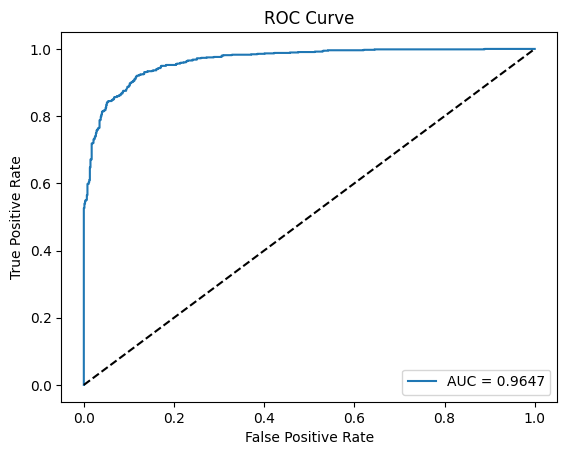

In [6]:
# -------------------------
# Test Evaluation
# -------------------------

model.eval()                                                   # put model in evaluation mode
all_labels = []                                                # store true labels
all_preds = []                                                 # store predicted labels
all_probs = []                                                 # store probabilities

with torch.no_grad():                                          # disable gradient calc
    
    for images, labels in test_loader:                         # Loop through test batches

        # MOVE TO DEVICE
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images).view(-1)
        probs = torch.sigmoid(outputs)                           # convert logits to probabilities

       
        predicted = (outputs > 0.5).float()                      # convert logits to predicted class if > 0,5 class 1 otherwise 0

        # Move results back to CPU for sklearn
        all_labels.extend(labels.cpu().numpy())                   # true labels
        all_preds.extend(predicted.cpu().numpy())                 # predicted labels
        all_probs.extend(probs.cpu().numpy())                     # predicted probabilities

# Compute performance metrics
precision = precision_score(all_labels, all_preds)               
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)
accuracy  = accuracy_score(all_labels, all_preds)
auroc = roc_auc_score(all_labels, all_probs)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# AUROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f'AUC = {auroc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()